# Projekt Marketinganalyse

Modulprojekt für die Vorlesung __Applied Statistics__  
Wintersemester 2018
Hochschule der Medien, Stuttgart 

_Dozent:_ Prof. Dr. Jan Kirenz  
_Studenten:_ Stephanie Flohr, Benedikt Haußner, Robert Masendorf

**Hinweis:** Zu korrekten Darstellung der Ergebnisse in den MarkDowns muss die Nbextension ```Python Markdown``` aktiviert sein. Zusätzlich muss ein ```Trusted```Kernel verwendet werden.

In [1]:
#import sys
#if not sys.warnoptions:
#import warnings
#warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
sns.set() 
%matplotlib inline 
plt.style.use('ggplot')
pd.set_option('display.max_columns',24)

## Ziel der Arbeit

Wir betrachten einen Datensatz, der __Kundendaten einer Autoversicherung__ enthält.  
Mittels statistischer Modelle sollen __folgende Ansätze__ verfolgt werden:
+ __Regression:__ Wir werden versuchen, den ```Customer Lifetime Value``` zu prognostizieren, also die Menge Geld, die der Kunde für das Unternehmen wert ist.
+ __Klassifikation:__ Der Datensatz enthält Angaben darüber, ob die Kunden auf einen Kundenansprache reagiert haben. Wir werden versuchen, die Kunden danach zu klassifizieren - können wir etwas darüber lernen, welche Attribute dafür sprechen, dass ein Kunde auf Werbung reagiert?

Für diesen Zweck sollen diverse statistische Modelle, aber auch uni- und bivariate Analysen sowie Visulaisierungen genutzt werden.

## Import der Daten und Betrachtung der Attribute

IBM hat im März 2015 den genutzten Datenbestand als Übungsbeispiel unter dem Namen `SAMPLE DATA: Marketing Customer Value Analysis`veröffentlicht. Das csv kann [hier](https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/) herunterleladen werden.

### Import der Daten

In [3]:
df = pd.read_csv('marketing_customer_marketing_raw_data.csv')

Der DataFrame hat __folgende Dimensionen__:
+ Anzahl der Attribute: {{df.shape[1]}}
+ Anzahl der Datensätze: {{df.shape[0]}}

In [4]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


### Beschreibung der Attribute
+ ```Customer_ID```: Eindeutig Kombination aus Buchstaben und Zahlen, zur Identifizierung des Kundens.  
+ ```State```: Bundesstaat in den Vereinigten Staaten, in welchem der Kunde wohnt.  
+ ```Customer_Lifetime_Value```: Durchschnittlicher Wert des Kundens für das Unternehmen während seines gesamten Lebenszyklus. Der Wert ist diskontiert auf den Betrachtungszeitpunkt.  
+ ```Response```: Binärer Wert, ob der Kunde auf die Marketingmaßnahme reagiert hat.  
+ ```Coverage```: Der aktuelle Tarif, in welchem sich der angesprochene Kunde befindet.  
+ ```Education```: Der Bildungsstatus des angesprochenen Kunden.  
+ ```Effective_To_Date```: Laufzeitende der aktuellen Versicherung.  
+ ```Employment_Status```: Arbeitsverhältnis des Kundens.
+ ```Gender```: Geschlecht des Kundens.  
+ ```Income```: Jährliches Einkommen des Kundens in Dollar.  
+ ```Location_Code```: Wohnumgebung des Kundens in Bezug auf die Flächenverdichtung.  
+ ```Marital_Status```: Familienstand des Kundens.  
+ ```Monthly_Premium_Auto```: Monatliche Versicherungsrate.  
+ ```Months_Since_Last_Claim```: Vergangene Monate seit dem die Versicherung zuletzt in Anspruch genommen wurde.  
+ ```Months_Since_Policy_Inception```: Vergangene Monate seit Beginn der aktuellen Verischerungspolice.  
+ ```Number_of_Open_Complaints```: Anzahl der noch offenen Schadensfälle.  
+ ```Number_of_Policies```: Gesamtanzahl der Policen seit Versicherungsbeginn.  
+ ```Policy_Type```: Feststellung, ob es sich um eine private, eine geschäftliche oder eine Sonderpolice handelt. 
+ ```Policy```: Akuelle Tarifstufe, in der der Kunde sich befindet.  
+ ```Renew_Offer_Type```: Das dem Kunden unterbreitete neue Angebot.  
+ ```Sales_Channel```: Der Kanal, über welchen das Angebot übermittelt wurde.  
+ ```Total_Claim_Amount```: In Anspruch genommene Versicherungssumme.  
+ ```Vehicle_Class```: Art des versicherten Autos.  
+ ```Vehicle_Size```: Größenordnung des versicherten Autos.

## Datenbereinigung

### Umbenennen der Spalten

Hier sehen wir die Spaltennamen, wie sie aktuell im Column-Index stehen:

In [5]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

Einige dieser Namen dürften im weiteren Verlauf für Probleme sorgen, da sie beispielsweise Leerzeichen enthalten. Daher benennen wir sie um:

In [6]:
df = df.rename(index=str, columns={"Customer":"Customer_ID",
                                   "Customer Lifetime Value":"Customer_Lifetime_Value",
                                   "Effective To Date":"Effective_To_Date", 
                                   "EmploymentStatus":"Employment_Status", 
                                   "Location Code":"Location_Code", 
                                   "Marital Status":"Marital_Status",
                                   "Monthly Premium Auto":"Monthly_Premium_Auto",
                                   "Months Since Last Claim":"Months_Since_Last_Claim",
                                   "Months Since Policy Inception":"Months_Since_Policy_Inception",
                                   "Number of Open Complaints":"Number_of_Open_Complaints",
                                   "Number of Policies":"Number_of_Policies",
                                   "Policy Type":"Policy_Type",
                                   "Renew Offer Type":"Renew_Offer_Type",
                                   "Sales Channel":"Sales_Channel",
                                   "Total Claim Amount":"Total_Claim_Amount",
                                   "Vehicle Class":"Vehicle_Class", 
                                   "Vehicle Size":"Vehicle_Size"})

### Prüfung auf Duplikate

Um sicherzustellen, dass die ```Customer-ID``` tatsächlich als Primärschlüssel dienen kann, prüfen wir die Datensätze auf Duplikate.

#### Einfacher Duplikatscheck

In [7]:
print('Anzahl Datensätze:\t\t{}'.format(len(df.Customer_ID)))
print('Anzahl eindeutiger Kunden-IDs:\t{}'.format(len(df.Customer_ID.value_counts())))

Anzahl Datensätze:		9134
Anzahl eindeutiger Kunden-IDs:	9134


Da beide Zahlen gleich sind, wissen wir, dass keine der Kunden-IDs doppelt angelegt wurde.

#### Komplexer Duplikatscheck

Allerdings kann es sein, dass ein Kunde doppelt mit zwei unterschiedlichen IDs angelegt wurde. Daher suchen wir nach Datensätzen, deren Werte für ein Subset der Attribute immer gleich ist - dies würde zumindest einen Anfangsverdacht rechtfertigen, der dann manuell überprüft werden müsste.  

Ein solches Subset könnte folgendermaßen aussehen:

In [8]:
duplicate_subset = ['State', 'Education', 'Employment_Status', 'Gender', 'Location_Code', 'Marital_Status']

Hier wurden alle Attribute berücksichtigt, die nichts mit der Versicherung an sich zu tun haben - denn letztere könnten sich ja je nach Aufnahme unterscheiden, beispielsweise, wenn eine neue Police abgeschlossen wurde, ohne dass der Vertreter gemerkt hat, dass der Kunde bereits in der Karte ist.  
Fraglich ist, wie viele Kombinationenen hier möglich sind:

In [9]:
combinations = 1
for attribute in duplicate_subset:
    combinations = combinations * df[attribute].nunique()
print("Mögliche Kombinationen:\t{}".format(combinations))

Mögliche Kombinationen:	2250


Bei {{df.shape[0]}} Datensätzen ergibt das so keinen Sinn, bei Gleichverteilung gibt es jede Kombination ca vier Mal. Trotzdem interessiert uns, wie viele Kunden "einzigartig" sind:

In [10]:
df.duplicated(subset=duplicate_subset, keep=False).value_counts()

True     8843
False     291
dtype: int64

Es gibt also 291 Kunden, die sicher keine Duplikate sind - eine manuelle Überprüfung bietet sich allerdings bei 8843 Kunden nicht an.

### Prüfung auf Missing Data

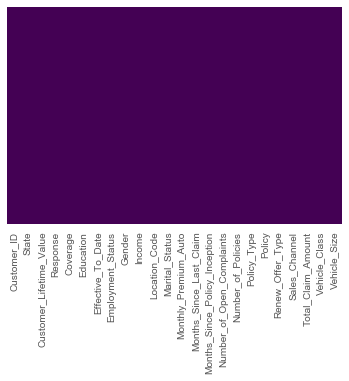

In [11]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
df.isnull().sum()

Customer_ID                      0
State                            0
Customer_Lifetime_Value          0
Response                         0
Coverage                         0
Education                        0
Effective_To_Date                0
Employment_Status                0
Gender                           0
Income                           0
Location_Code                    0
Marital_Status                   0
Monthly_Premium_Auto             0
Months_Since_Last_Claim          0
Months_Since_Policy_Inception    0
Number_of_Open_Complaints        0
Number_of_Policies               0
Policy_Type                      0
Policy                           0
Renew_Offer_Type                 0
Sales_Channel                    0
Total_Claim_Amount               0
Vehicle_Class                    0
Vehicle_Size                     0
dtype: int64

Wir sehen dass __keine Daten fehlen__, also keine Gegenmaßnahmen (Ausschluss der betroffenen Datensätze, Imputation, ect) getroffen werden müssen.

### Anpassung der Datentypen

Nachdem wir augenscheinlich auch kategoriale Daten vorliegen haben, diese aber beim Import nicht automatisiert erkannt werden, werden wir auch die Datentypen abändern.  
Dabei legen wir auch speziell Wert auf eine effiziente Datenhaltung, einen entsprechenden Blogpost findet man zb bei [Dataquest](https://www.dataquest.io/blog/pandas-big-data/).

#### Ist-Zustand vor der Transformation

Bevor wir Umwandlungen vornehmen, prüfen wir den Ist-Zustand.  
Hier finden sich die __aktuellen Datentypen__, auch der __belegte Speicherplatz__ wird gemessen:

In [13]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null object
Employment_Status                9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies               9134 

#### Umwandlung zu Datetime

In [14]:
df.Effective_To_Date = pd.to_datetime(df.Effective_To_Date)

#### Umwandlung in kategoriale Variablen

In [15]:
df.State = pd.Categorical(df.State)
df.Response = pd.Categorical(df.Response)
df.Coverage = pd.Categorical(df.Coverage)
df.Education = pd.Categorical(df.Education)
df.Employment_Status = pd.Categorical(df.Employment_Status)
df.Gender = pd.Categorical(df.Gender)
df.Location_Code = pd.Categorical(df.Location_Code)
df.Marital_Status = pd.Categorical(df.Marital_Status)
df.Policy_Type = pd.Categorical(df.Policy_Type)
df.Policy = pd.Categorical(df.Policy)
df.Renew_Offer_Type = pd.Categorical(df.Renew_Offer_Type)
df.Sales_Channel = pd.Categorical(df.Sales_Channel)
df.Vehicle_Class = pd.Categorical(df.Vehicle_Class)
df.Vehicle_Size = pd.Categorical(df.Vehicle_Size)

Zusätzlich werden die ordinalen Attribute als solche gekennzeichnet und die möglichen Werte in die richtige Reiehnfolge gebracht:

In [16]:
df.Coverage = df.Coverage.cat.reorder_categories(['Basic',
                                                  'Extended',
                                                  'Premium'],
                                                 ordered=True)
df.Coverage.dtype

CategoricalDtype(categories=['Basic', 'Extended', 'Premium'], ordered=True)

In [17]:
df.Education = df.Education.cat.reorder_categories(['High School or Below',
                                                    'College',
                                                    'Bachelor',
                                                    'Master',
                                                    'Doctor'],
                                                   ordered=True)
df.Education.dtype

CategoricalDtype(categories=['High School or Below', 'College', 'Bachelor', 'Master',
                  'Doctor'],
                 ordered=True)

In [18]:
df.Vehicle_Size = df.Vehicle_Size.cat.reorder_categories(['Small',
                                                          'Medsize',
                                                          'Large'],
                                                         ordered=True)
df.Vehicle_Size.dtype

CategoricalDtype(categories=['Small', 'Medsize', 'Large'], ordered=True)

#### Umwandlung der Integervariablen

Unsere Attribute haben __folgende Minimal- und Maximalwerte__:

In [19]:
df.describe(include=np.int_).loc[['min', 'max']]

,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies
min,0.0,61.0,0.0,0.0,0.0,1.0
max,99981.0,298.0,35.0,99.0,5.0,9.0


Wir können also auf die __Abbildung von negativen Zahlen verzichten__.  
Folgende __unsigned Datentypen__ mit sich unterscheidenden Wertebereichen stehen für Integer-Werte zur Verfügung:

In [20]:
pd.DataFrame(index=['max'], data={"uint8":[np.iinfo("uint8").max],
                                  "uint16":[np.iinfo("uint16").max],
                                  "uint32":[np.iinfo("uint32").max],
                                  "uint64":[np.iinfo("uint64").max]})

,uint16,uint32,uint64,uint8
max,65535,4294967295,18446744073709551615,255


Praktischerweise gibt es das Argument ```downcast```, das bei einem ```apply``` automatisch den Datentyp mit dem niedrigsten Speicherplatzverbrauch nutzt - nur dass es eben ```unsigned``` sein soll, muss man der Funktion mitgeben:

In [21]:
int_columns = df.select_dtypes(include='int').columns
df[int_columns] = df[int_columns].apply(pd.to_numeric,downcast='unsigned')

In [22]:
df[int_columns].dtypes

Income                           uint32
Monthly_Premium_Auto             uint16
Months_Since_Last_Claim           uint8
Months_Since_Policy_Inception     uint8
Number_of_Open_Complaints         uint8
Number_of_Policies                uint8
dtype: object

Wir sehen: das hat gut geklappt!

### Umwandlung der Float Variablen

Ebenso gehen wir für die Float-Variablen vor:

In [23]:
df.describe(include="float").loc[['min', 'max']]

,Customer_Lifetime_Value,Total_Claim_Amount
min,1898.007675,0.099007
max,83325.381190,2893.239678


In [24]:
pd.DataFrame(index=['max'], data={"float16":[np.finfo("float16").max],
                                  "float32":[np.finfo("float32").max],
                                  "float64":[np.finfo("float64").max]})

,float16,float32,float64
max,65504.0,3.402823e+38,1.797693e+308


In [25]:
float_columns = df.select_dtypes(include='float').columns
df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast='float')

In [26]:
df[float_columns].dtypes

Customer_Lifetime_Value    float32
Total_Claim_Amount         float32
dtype: object

Auch dieser Schritt war erfolgreich.

### Ist-Zustand nach der Transformation

Jetzt wollen wir noch prüfen, wie sich die Änderungen auf den DataFrame auswirken:

In [27]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer_ID                      9134 non-null object
State                            9134 non-null category
Customer_Lifetime_Value          9134 non-null float32
Response                         9134 non-null category
Coverage                         9134 non-null category
Education                        9134 non-null category
Effective_To_Date                9134 non-null datetime64[ns]
Employment_Status                9134 non-null category
Gender                           9134 non-null category
Income                           9134 non-null uint32
Location_Code                    9134 non-null category
Marital_Status                   9134 non-null category
Monthly_Premium_Auto             9134 non-null uint16
Months_Since_Last_Claim          9134 non-null uint8
Months_Since_Policy_Inception    9134 non-null uint8
Number_of_Open_Complaints        9134 non-null uint8
Number_of_Po

__Wir sehen:__
+ Die Datentypen wurden sinnvoll umgewandelt. Einzig ```Customer_ID``` wurde nicht angefasst, da hier aber ausschließlich unique Werte vorliegen, kostet der Wörterbuchansatz von ```Categorical``` mehr, als er bringt.
+ Der Speicherplatzbedarf ist fast um den ```Faktor 10``` gesunken - was im ```MB```-Bereich kaum einen Unterschied macht, sehr wohl aber, sobald man mit ```GB``` arbeitet.

## Univariate Analyse

Im Folgenden unterziehen wir alle Attribute einer univariaten Analyse.

### Hilfsfunktionen
Um uns später das Leben einfacher und den Code übersichtlicher zu machen, definieren wir uns Helper-Funktionen:

In [28]:
def univariat_analysis_number(dataframe, column):
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t{}".format(dataframe[column].count()))
    print("Kleinster Betrag:\t{}".format(dataframe[column].min()))
    print("Median:\t\t\t{}".format(dataframe[column].median()))
    print("Durchschnitt:\t\t{0:.2f}".format(dataframe[column].mean()))
    print("Größter Betrag:\t\t{}".format(dataframe[column].max()))

    pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=True)
    plt.axvline(x=dataframe[column].mean(), color='blue')
    plt.show()
    
    if dataframe[column].max() >= 3 * dataframe[column].quantile(q=0.75):
        pd.DataFrame(dataframe[column]).boxplot(figsize=(12,1), vert=False, showfliers=False)
        plt.axvline(x=dataframe[column].mean(), color='blue')
        plt.show()
    print("*"*100+"\n")

In [29]:
def univariat_analysis_categorical(dataframe, column, kind='bar', figsize=(11,5)):
    print(dataframe[column].name.upper()+"\n")
    print("Anzahl Datensätze:\t\t\t{}".format(dataframe[column].count()))
    print("Häufigkeit des häufigsten Wertes:\t{}".format(dataframe.groupby(column)[column].count().max()))
    print("Häufigkeit des seltensten Wertes:\t{}".format(dataframe.groupby(column)[column].count().min()))
    ax = dataframe.groupby(column)[column].count().plot(kind=kind, rot=0, figsize=figsize)
    if kind == 'bar':
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
    plt.ylabel("Anzahl")
    plt.show()
    print("*"*100+"\n")

### Numerische Variablen

Wir beginnen mit den numerischen Attributen:

In [30]:
df.select_dtypes(include=np.number).columns.tolist()

['Customer_Lifetime_Value',
 'Income',
 'Monthly_Premium_Auto',
 'Months_Since_Last_Claim',
 'Months_Since_Policy_Inception',
 'Number_of_Open_Complaints',
 'Number_of_Policies',
 'Total_Claim_Amount']

#### Customer Lifetime Value

CUSTOMER_LIFETIME_VALUE

Anzahl Datensätze:	9134
Kleinster Betrag:	1898.0076904296875
Median:			5780.18212890625
Durchschnitt:		8004.93
Größter Betrag:		83325.3828125


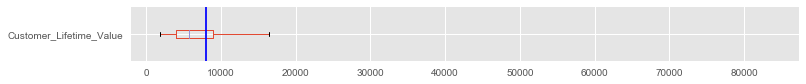

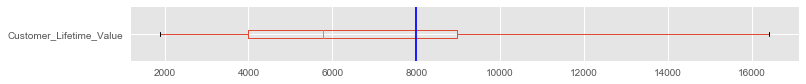

****************************************************************************************************



In [31]:
univariat_analysis_number(df, 'Customer_Lifetime_Value')

Nachdem hier gilt: ```Mean > Median``` folgern wir, dass wir ein paar __heftige Ausreißer__ in den Daten haben, die den Durchschnitt start verzerren.  
Eventuell sollten diese speziell behandel werden, dafür muss später das ```Residuals-vs-Leverage```-Diagramm genau betrachtet werden.

#### Income

INCOME

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			33889.5
Durchschnitt:		37657.38
Größter Betrag:		99981


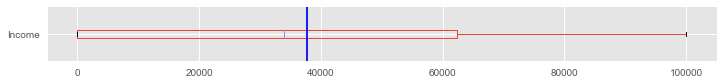

****************************************************************************************************



In [32]:
univariat_analysis_number(df, 'Income')

Das Einkommen scheint __einigermaßen normalverteilt__ zu sein, was uns entgegenkommt.  
Nachdem das erste Quantil fast bei ```0``` liegt, haben wir es trotzdem mit einer linkssteilen Verteilung zu tun.

#### Monthly_Premium_Auto

MONTHLY_PREMIUM_AUTO

Anzahl Datensätze:	9134
Kleinster Betrag:	61
Median:			83.0
Durchschnitt:		93.22
Größter Betrag:		298


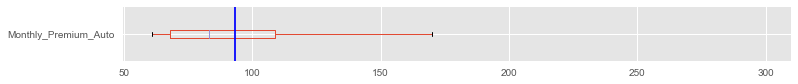

****************************************************************************************************



In [33]:
univariat_analysis_number(df, 'Monthly_Premium_Auto')

Auch bei den monatlichen Prämien gibt es __wieder Ausreißer__ nach oben.  
Versichert sind auch Menschen, die das __Dreifache des Durchschnitts__ zahlen.

#### Months_Since_Last_Claim

MONTHS_SINCE_LAST_CLAIM

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			14.0
Durchschnitt:		15.10
Größter Betrag:		35


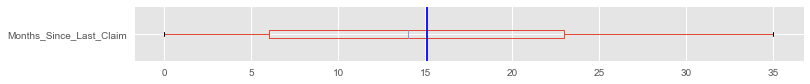

****************************************************************************************************



In [34]:
univariat_analysis_number(df, 'Months_Since_Last_Claim')

Hier sehen wir eine __wunderschöne Normalverteilung__.  
Wobei wir uns als Firma eventuell fragen sollten, warum Ansprüche im Durchschnitt 1,25 Jahre offen sind.

#### Months_Since_Policy_Inception

MONTHS_SINCE_POLICY_INCEPTION

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			48.0
Durchschnitt:		48.06
Größter Betrag:		99


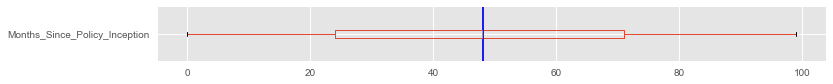

****************************************************************************************************



In [35]:
univariat_analysis_number(df, 'Months_Since_Policy_Inception')

Hier sehen wir eine __nahezu perfekte Normalverteilung__.

#### Number_of_Open_Complaints

NUMBER_OF_OPEN_COMPLAINTS

Anzahl Datensätze:	9134
Kleinster Betrag:	0
Median:			0.0
Durchschnitt:		0.38
Größter Betrag:		5


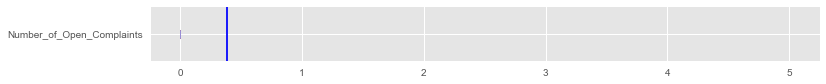

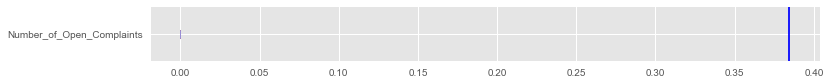

****************************************************************************************************



In [36]:
univariat_analysis_number(df, 'Number_of_Open_Complaints')

Wir sehen schon keine Box mehr - es gibt fast keine offenen Beschwerden:

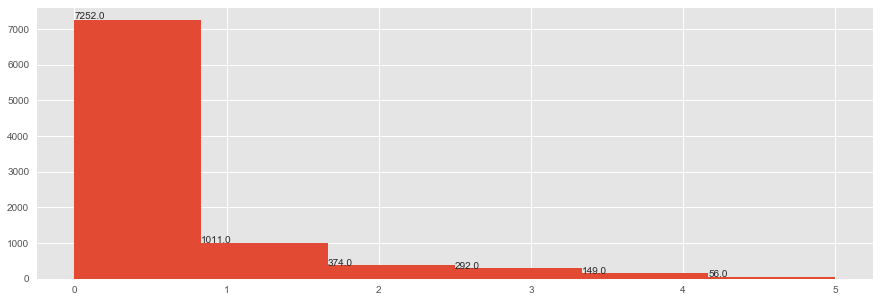

In [37]:
ax = df.Number_of_Open_Complaints.hist(figsize=(15,5), bins=df.Number_of_Open_Complaints.nunique())
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005))
plt.show()

#### Number_of_Policies

NUMBER_OF_POLICIES

Anzahl Datensätze:	9134
Kleinster Betrag:	1
Median:			2.0
Durchschnitt:		2.97
Größter Betrag:		9


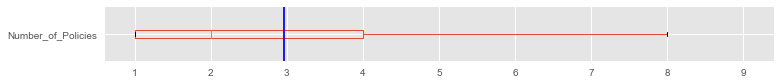

****************************************************************************************************



In [38]:
univariat_analysis_number(df, 'Number_of_Policies')

Auch hier gibt es __wieder ein paar Ausreißer nach oben__.  
Wir gehen wegen des Aufbaus des Datenbestandes davon aus, dass ein Versicherungsnehmen nur ein Auto gleichzeitig versichern kann, eine Menge Kunden versichern also auch andere Dinge bei uns.

#### Total_Claim_Amount

TOTAL_CLAIM_AMOUNT

Anzahl Datensätze:	9134
Kleinster Betrag:	0.0990070030093193
Median:			383.9454345703125
Durchschnitt:		434.09
Größter Betrag:		2893.23974609375


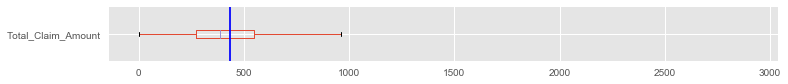

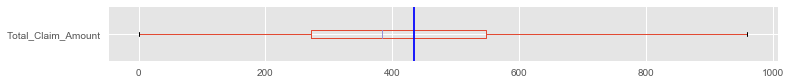

****************************************************************************************************



In [39]:
univariat_analysis_number(df, 'Total_Claim_Amount')

Interessant ist auch hier zu sehen: Median und Durchschnitt sind nicht allzuweit voneinander entfernt, allerdings haben ein paar wenige Kunden sehr hohe Forderungen gestellt, die in der Realität natürlich überprüft werden müssten.  
Die ausreißenden Datensätze sollten wir uns auch genauer anschauen, wenn wir das ```Residuals-vs-Leverage```-Diagramm interpretieren.

### Kategoriale Variablen

Nachdem wir es mit einer großen Zahl an kategorialen Attributen zu tun haben, besprechen wir nur die auffälligsten hier einzeln, für die restlichen werden nur die Plots erzeugt.  
Folgende kategoriale Variablen finden sich im Datenbestand:

In [40]:
categorical_columns = df.select_dtypes(include="category").columns.tolist()
categorical_columns

['State',
 'Response',
 'Coverage',
 'Education',
 'Employment_Status',
 'Gender',
 'Location_Code',
 'Marital_Status',
 'Policy_Type',
 'Policy',
 'Renew_Offer_Type',
 'Sales_Channel',
 'Vehicle_Class',
 'Vehicle_Size']

#### Response

RESPONSE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	7826
Häufigkeit des seltensten Wertes:	1308


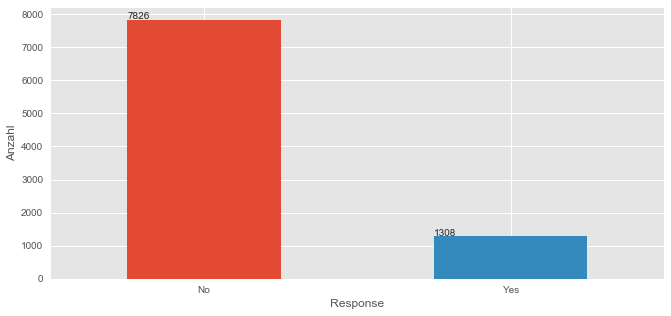

****************************************************************************************************

Anteil der Rückmeldungen:	0.14320122618786948


In [41]:
column = 'Response'
univariat_analysis_categorical(df, column)
print("Anteil der Rückmeldungen:\t{}".format(df[column].value_counts()['Yes']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: wir haben 14% Rückmeldungen. Dies ist für eine Marketingmaßnahme generell nicht als schlecht anzusehen.  
Nachdem ```Response``` unsere Zielvariable für die Klassifikation ist, sehen wir hier allerdings Probleme auf uns zukommen, da ein hoher Bias vorliegt.

#### Employment_Status

EMPLOYMENT_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5698
Häufigkeit des seltensten Wertes:	282


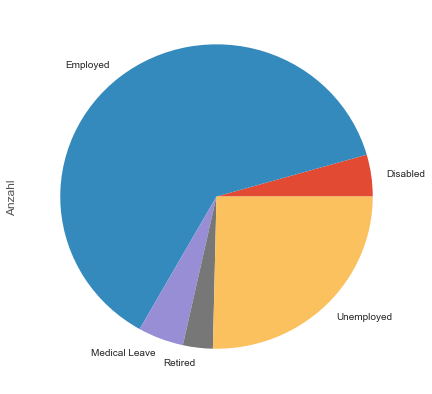

****************************************************************************************************

Anteil der Arbeitslosen:	0.25366761550251804


In [42]:
column = 'Employment_Status'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Arbeitslosen:\t{}".format(df[column].value_counts()['Unemployed']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Interessant ist zu beobachten, dass wir einen Arbeitslosenanteil von 25% haben - speziell, wenn man auch den ```Policy_Type``` betrachtet:

#### Policy_Type

POLICY_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6788
Häufigkeit des seltensten Wertes:	378


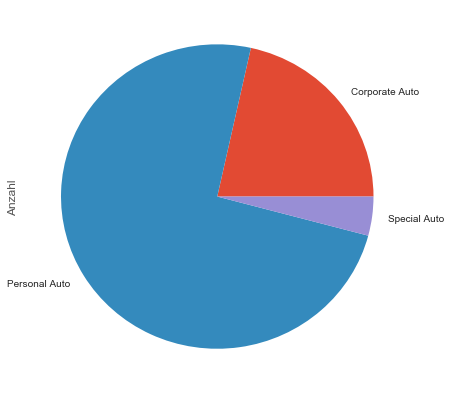

****************************************************************************************************

Anteil der Firmenwägen:	0.2154587256404642


In [43]:
column = 'Policy_Type'
univariat_analysis_categorical(df, column, 'pie', (7,7))
print("Anteil der Firmenwägen:\t{}".format(df[column].value_counts()['Corporate Auto']/df[column].count()))
if column in categorical_columns: categorical_columns.remove(column)

Wir sehen: 22% der versicherten Autos sind Firmenwägen - kommt es eventuell zu Überschneidungen zwischen Firmenwägen und Arbeitslosen? Dieser Frage werden wir bei den bivariaten Analysen nachgehen.

#### Weitere kategoriale Variablen

Hier wie angekündigt die verbleibenden Attribute.  
Schön ist auch hier zu sehen, wie die Plots der ordinalen Daten sortiert sind.

STATE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3150
Häufigkeit des seltensten Wertes:	798


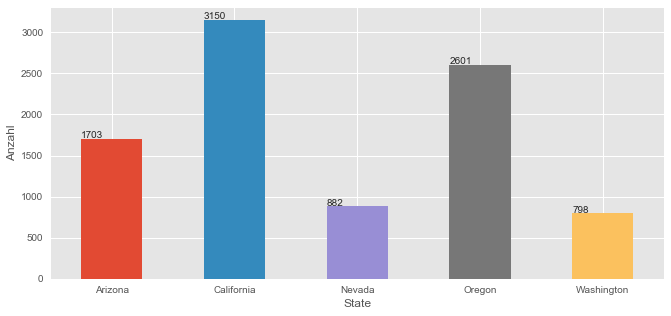

****************************************************************************************************

COVERAGE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5568
Häufigkeit des seltensten Wertes:	824


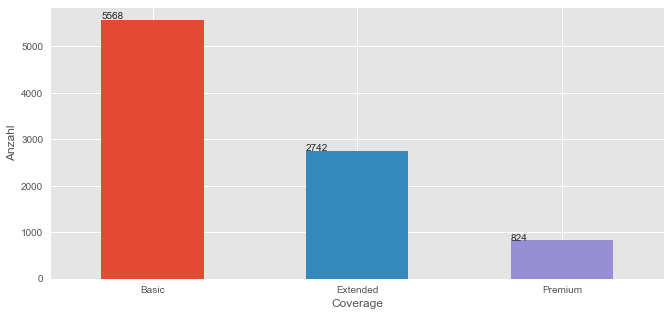

****************************************************************************************************

EDUCATION

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	2748
Häufigkeit des seltensten Wertes:	342


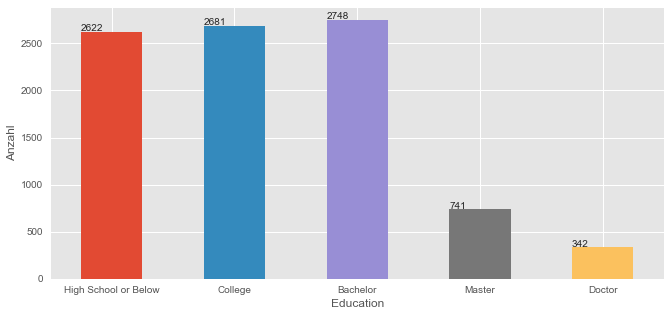

****************************************************************************************************

GENDER

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4658
Häufigkeit des seltensten Wertes:	4476


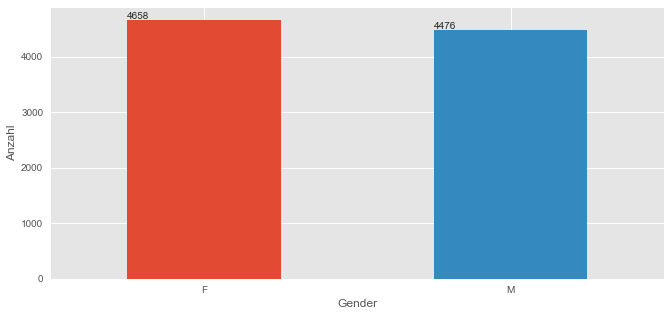

****************************************************************************************************

LOCATION_CODE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5779
Häufigkeit des seltensten Wertes:	1582


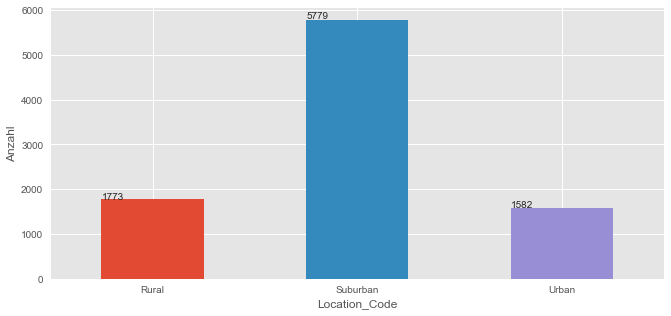

****************************************************************************************************

MARITAL_STATUS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	5298
Häufigkeit des seltensten Wertes:	1369


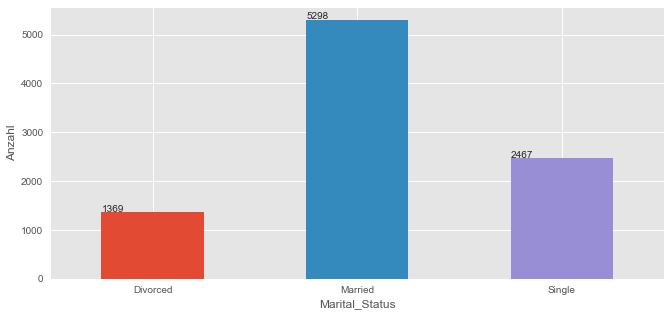

****************************************************************************************************

POLICY

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3426
Häufigkeit des seltensten Wertes:	66


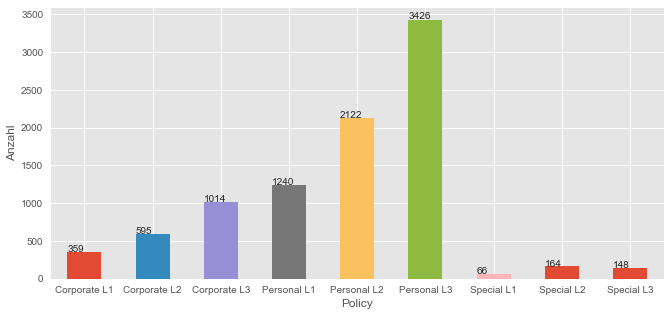

****************************************************************************************************

RENEW_OFFER_TYPE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3752
Häufigkeit des seltensten Wertes:	1024


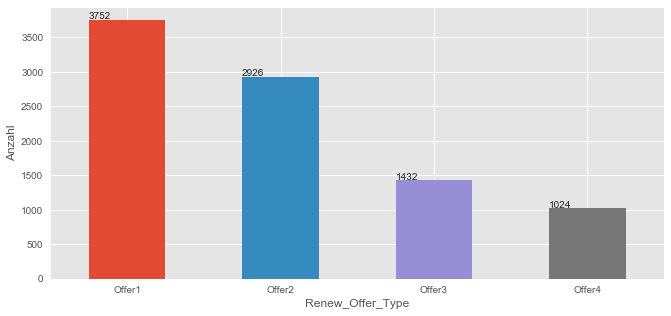

****************************************************************************************************

SALES_CHANNEL

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	3477
Häufigkeit des seltensten Wertes:	1325


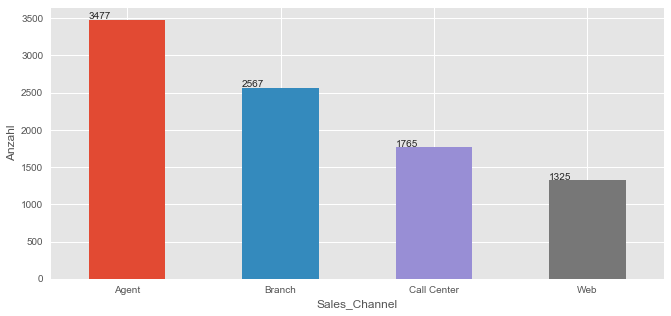

****************************************************************************************************

VEHICLE_CLASS

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	4621
Häufigkeit des seltensten Wertes:	163


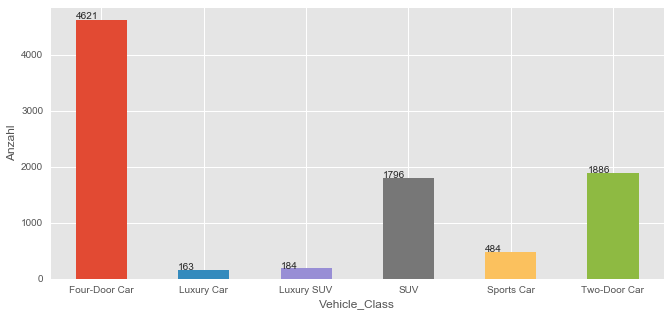

****************************************************************************************************

VEHICLE_SIZE

Anzahl Datensätze:			9134
Häufigkeit des häufigsten Wertes:	6424
Häufigkeit des seltensten Wertes:	946


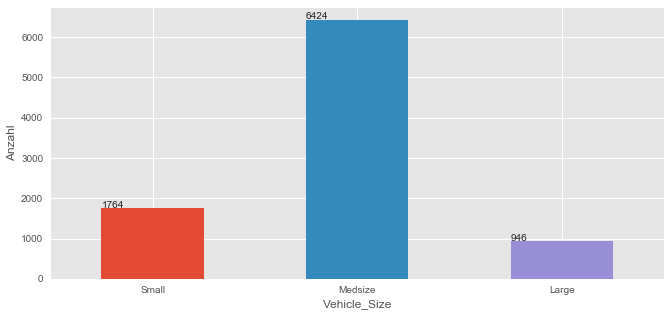

****************************************************************************************************



In [44]:
for column in categorical_columns:
    univariat_analysis_categorical(df, column)

### Timestamp

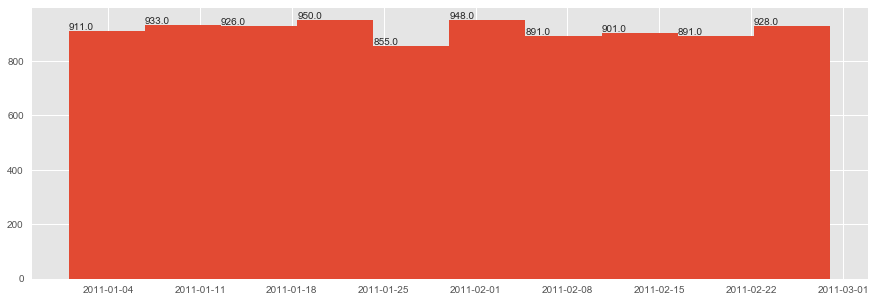

In [45]:
ax = df.Effective_To_Date.hist(figsize=(15,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.005))
plt.show()

__Wir sehen:__
+ Der Datenbestand umfasst zwei Monate.
+ Die Enddaten der Policen sind gleichverteilt, man kann also auch keinen Peak oder ähnliches zu Jahresbeginn feststellen.

__Daraus folgt:__  
+ Eine Zeitreihenanalyse ergibt für diesen kurzen Zeitraum keinen Sinn.

## Bi- und evtl multivariate Analysen

Im Folgenden betrachten wir die Variablen und ihre Wechselwirkungen untereinander.

### Kombination: _Employment Status_ und _Policy Type_

Wie bereits angesprochen interessiert uns, wie viele Policen wir an Arbeitslose ausgegeben haben - hier liegt eventuell eine Fehlerquelle oder Mißbrauch vor.

In [46]:
df[(df.Employment_Status=='Unemployed') & (df.Policy_Type=='Corporate Auto')].Customer_ID.count()

504

Hier sollten wir uns als Firma tatsächlich Gedanken machen - __da kann etwas nicht stimmen__.  
Für unsere weiteren Auswertungen ignorieren wir diesen Fakt.

### Scatterplot

Wir beginnen mit einem Scatterplot, der die einzelenen Attribute zueinander in Beziehung setzt.  
Können wir hier bereits eine Aussage über den weiteren Verlauf der Arbeit treffen?

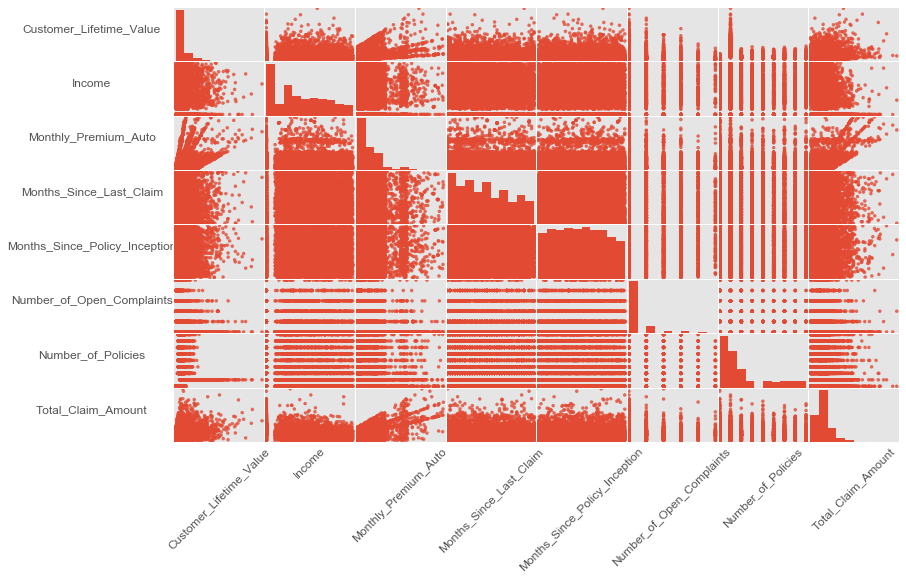

In [47]:
sm = pd.plotting.scatter_matrix(df, alpha=0.8, figsize=(13, 8))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.9,0.5) for s in sm.reshape(-1)]
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

__Das sieht leider überhaupt nicht gut aus:__  
Wir können keinen einzigen linearen Zusammenhang ausmachen, an dem man sich für Prognosen eventuell festhalten könnte. Fast alle Scatterplots sehen aus, wie mit einem Schrotgewehr produziert.

### Korrelations-Matrix

Der nächste Schritt ist das Plotten der Korrelations-Matrix, eventuell können wir in den Zahlen bessere Informationen finden, als in der Visualisierung über einen Scatterplot.

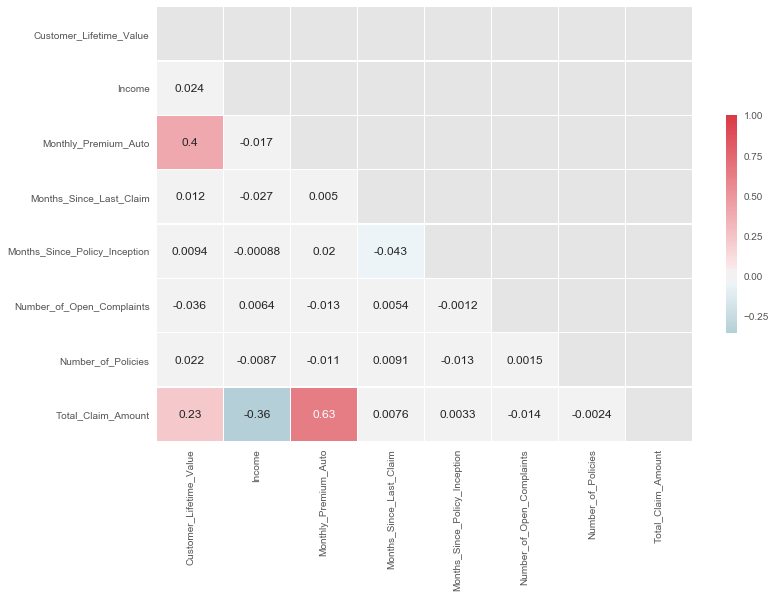

In [48]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Leider finden sich hier __nur die numerischen Attribute__ und nicht wie erhofft auch die (ja dank Dictionary-Approch als ```int``` hinterlegten) kategorialen Attribute.  
Das __Einbeziehen der kategorialen Attribute__  ist umstritten, da auch bei Sortierung eine geeignete Abbildung über ```int``` nicht gewährleistet ist.  
__Ein Beispiel:__ Ist denn eine ```extended``` Deckung doppelt so viel "wert" wie eine ```basic```?

Trotzdem wollen wir es versuchen und wandeln in ```uint8``` um:

In [49]:
df_for_corr = df.copy()

df_for_corr.Coverage.cat.categories = [0,1,2]
df_for_corr.Coverage = df_for_corr.Coverage.astype('uint8')

df_for_corr.Education.cat.categories = [0,1,2,3,4]
df_for_corr.Education = df_for_corr.Education.astype('uint8')

df_for_corr.Vehicle_Size.cat.categories = [0,1,2]
df_for_corr.Vehicle_Size = df_for_corr.Vehicle_Size.astype('uint8')

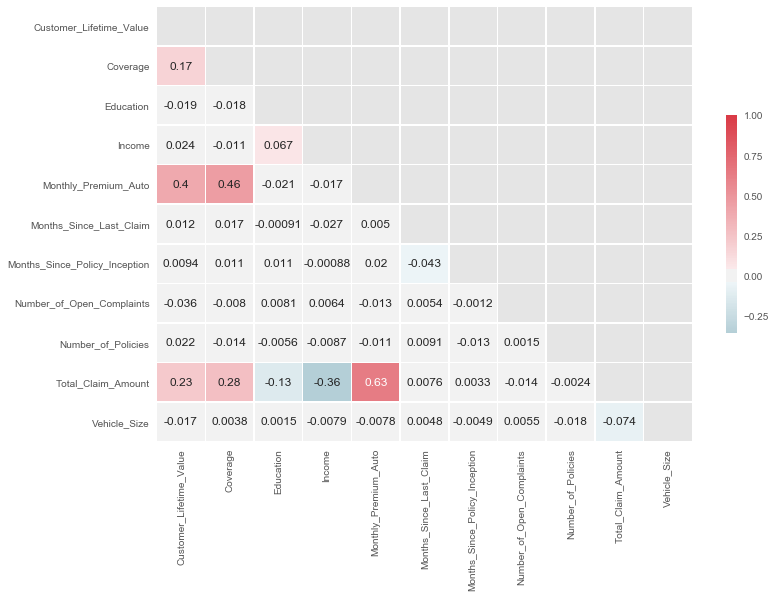

In [50]:
corr = df_for_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

__Wir sehen:__
+ Unsere Zielvariable ```Customer_Lifetime_Value``` korreliert mit:
    + ```Monthly_Premium_Auto```
    + ```Total_Claim_Amount```
    + ```Coverage```
    + Dabei ist anzumerken, dass auch diese drei untereinander korrelieren - was bei fachlicher Betrachtung Sinn ergibt:
        + Wenn ein Fahrer eine hohe Schadenssumme verursacht, wird er eher gewillt sein, auf eine höhere Deckung umzusteigen - oder eventuell andersherum.
        + Wenn ein Fahrer eine hohe Schadenssumme verursacht, wird er von der Versicherung zu teureren Raten verdonnert, was wiederum potentiell in einem höheren Kundenwert resultiert.
+ Unsere Zielvariable ```Response``` ist nicht in der Korrelationsmatrix enthalten, da HIER GEHTS WEITER
    
Generell ziehen wir als Fazit, dass eine Modellierung 

### Zusammenhang mit Zielvariablen für Klassifikation

Weil ja Zielvariable nominal und damit nicht in Korrelation enthalten, hier so mit visuell.

In [51]:
num_columns_for_corr = df.select_dtypes(include=np.number).columns.tolist()
cat_columns_for_corr = df.select_dtypes(include="category").columns.tolist()
cat_columns_for_corr.remove('Response')

#### Numerische Variablen

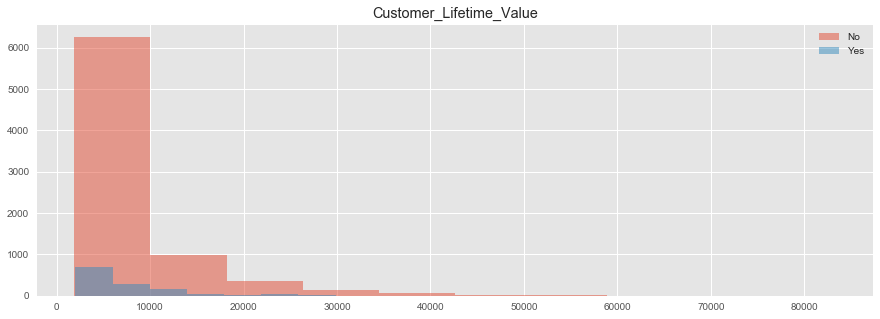

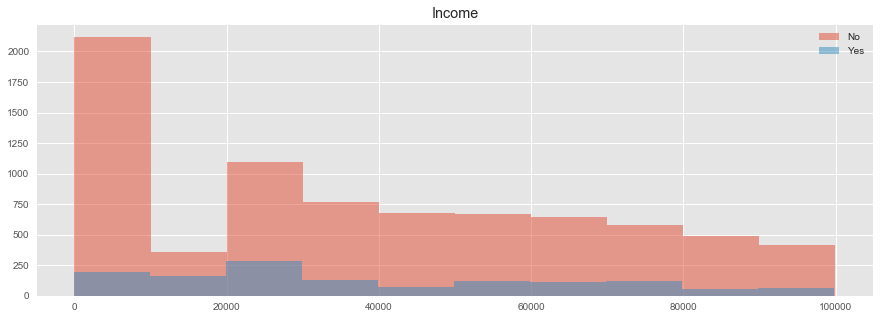

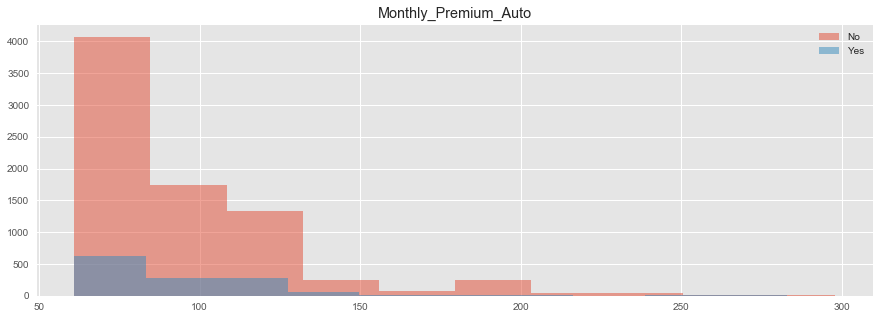

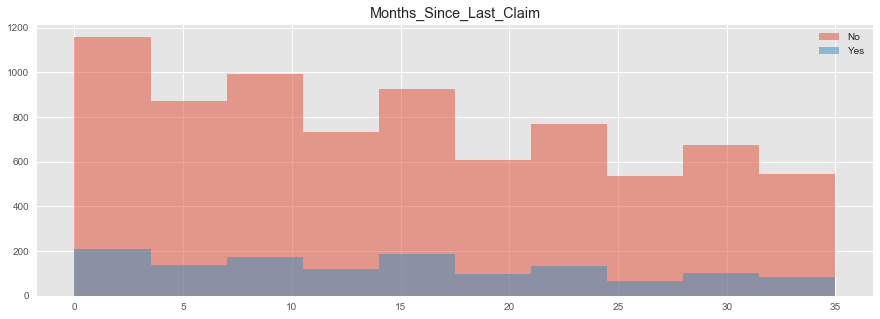

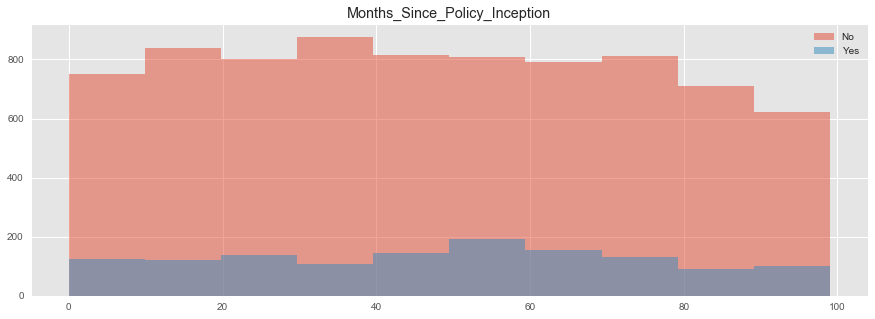

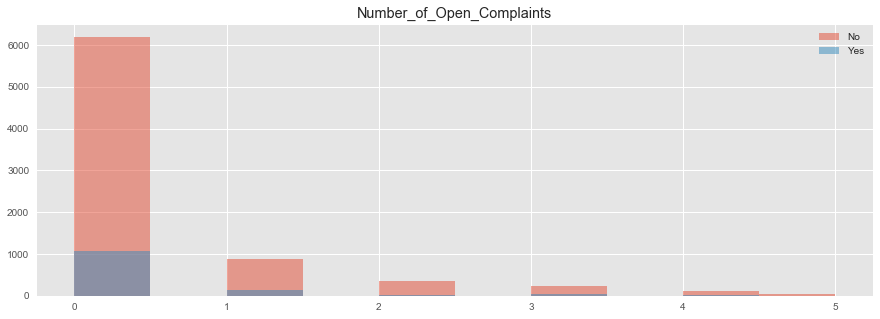

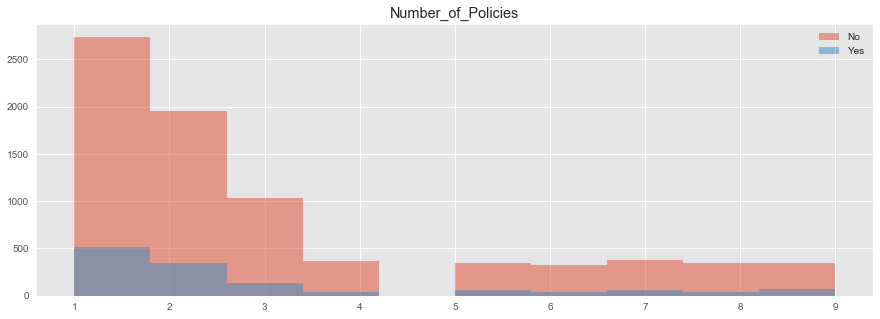

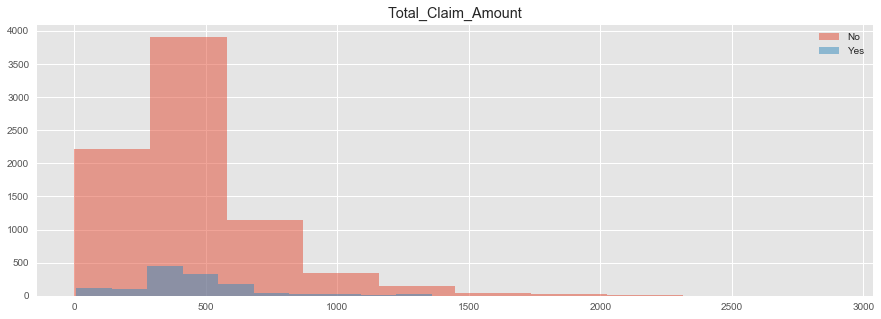

In [52]:
for column in num_columns_for_corr:
    groups = df.groupby('Response')[column]
    fig, ax = plt.subplots()
    for group, variable in groups:
        variable.hist(label=group, alpha=.5, ax=ax, figsize=(15,5))
    ax.legend()
    plt.title(column)

#### Kategoriale Variablen

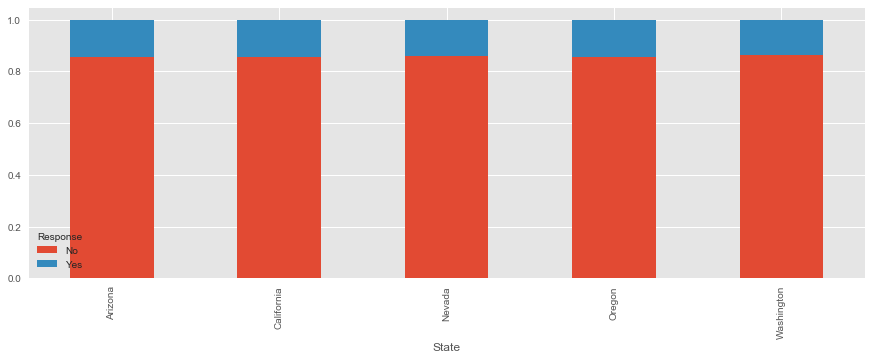

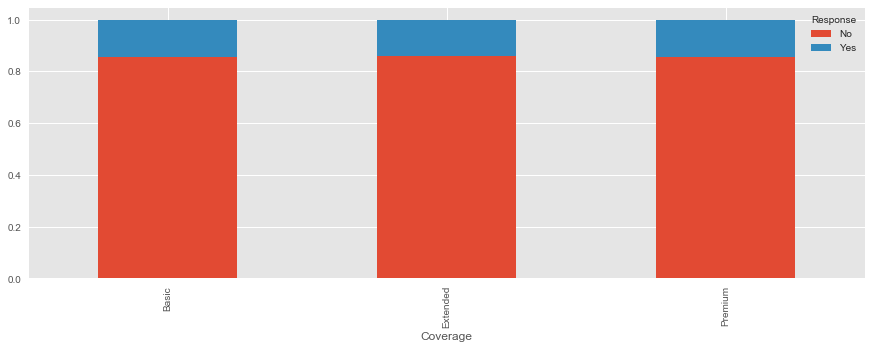

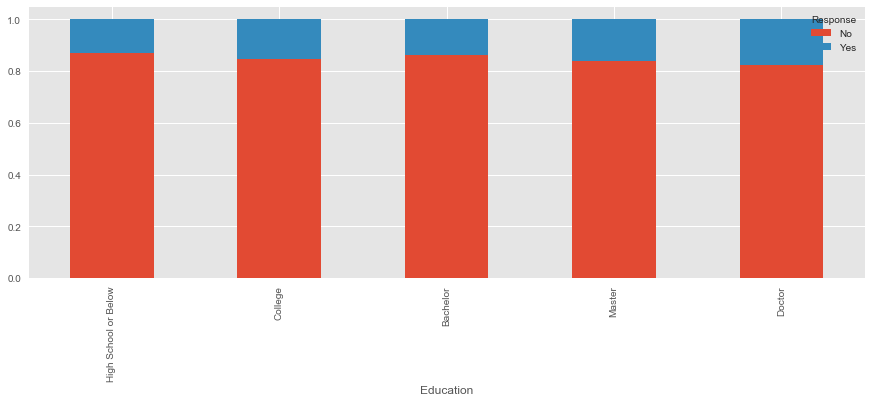

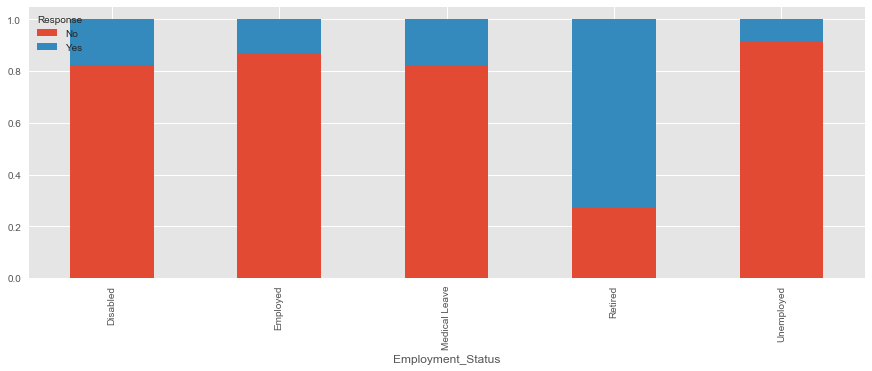

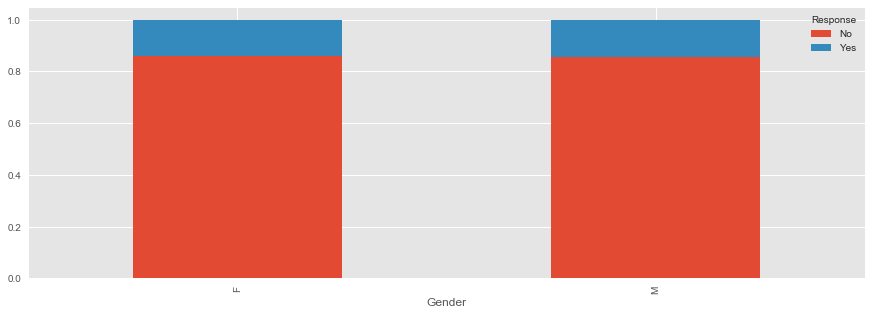

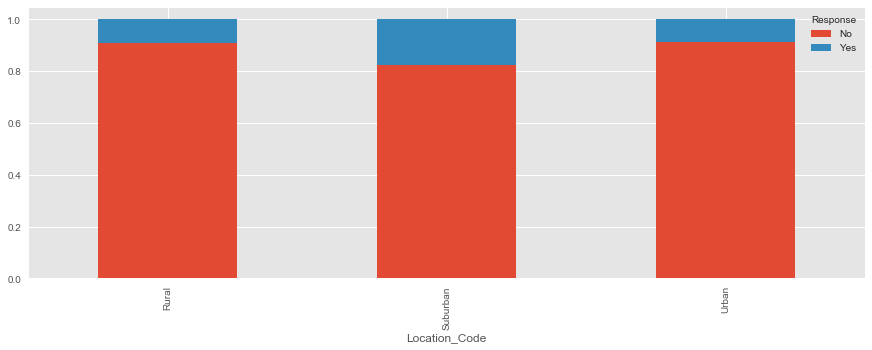

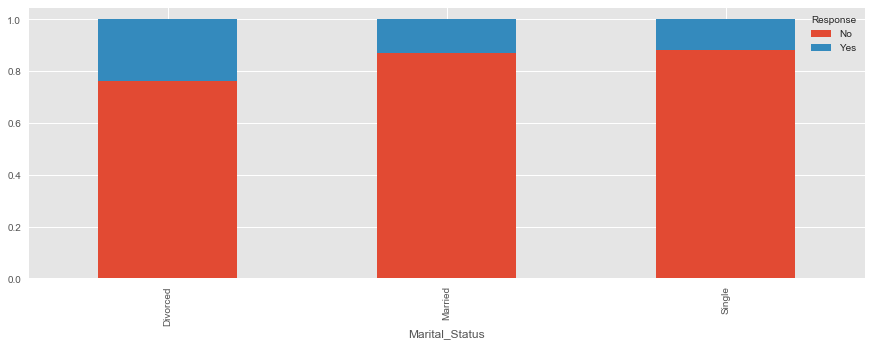

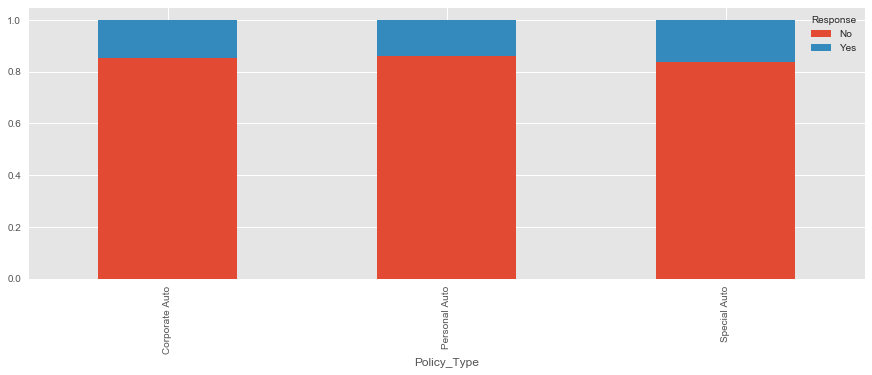

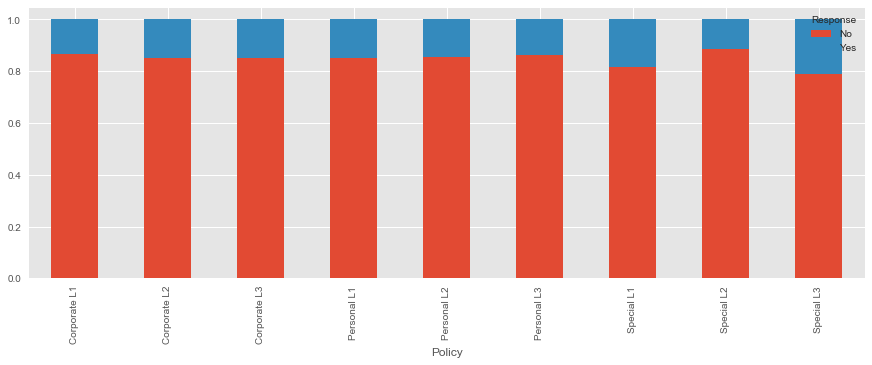

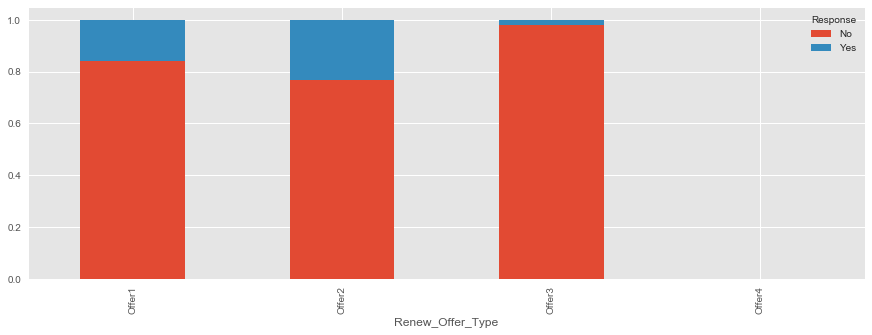

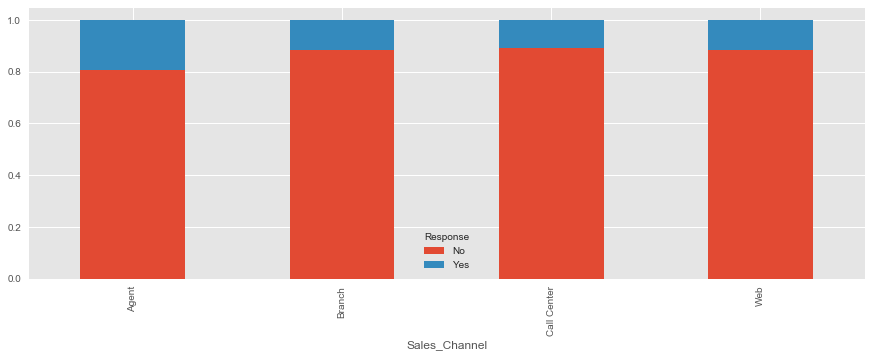

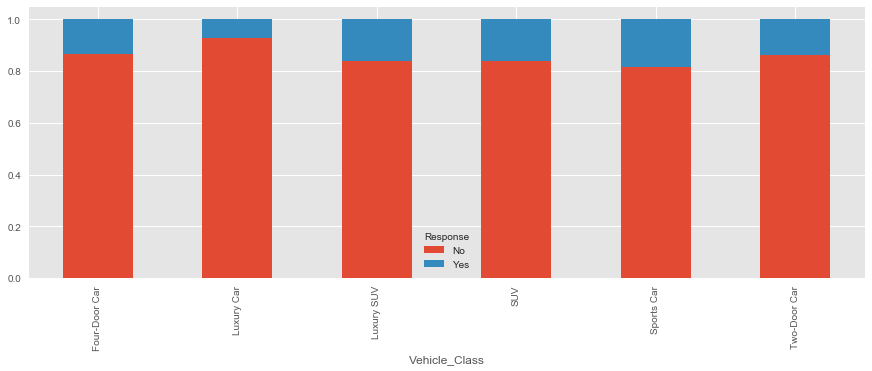

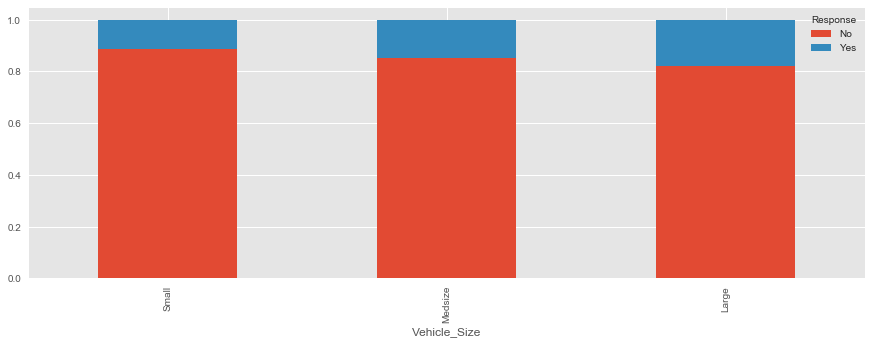

In [53]:
for column in cat_columns_for_corr:
    plot_df = pd.DataFrame(df.groupby(by=[column, 'Response'])['Customer_ID'].count()).unstack()
    plot_df.columns = plot_df.columns.droplevel()
    plot_df.columns = plot_df.columns.astype('object')
    plot_df['total'] = plot_df.apply(lambda row: row.Yes+row.No, axis=1)
    plot_df.Yes = plot_df.apply(lambda row: row.Yes / row.total, axis=1)
    plot_df.No = plot_df.apply(lambda row: row.No / row.total, axis=1)
    plot_df.drop(columns='total', inplace=True)
    plot_df.plot(kind='bar', stacked=True, figsize=(15,5))

## Modellberechnung Regression: Customer Lifetime Value

### One-Hot-Encoding

In [54]:
df_ohe = pd.get_dummies(df, columns=cat_columns_for_corr)
df_ohe.columns = df_ohe.columns.str.replace(' ', '')
df_ohe.columns = df_ohe.columns.str.replace('-', '_')

### Baseline: OLS mit statsmodels

Hier Helper-Function:

In [55]:
def get_attributes_because_patsy_sucks(list_of_attributes, comma=True):
    string_to_copy = ""
    for attribute in list_of_attributes:
        if comma:
            string_to_copy = "{}, '{}'".format(string_to_copy, attribute)
        else:
            string_to_copy = "{} + {}".format(string_to_copy, attribute)
    return string_to_copy

In [56]:
get_attributes_because_patsy_sucks(df_ohe.columns.tolist())

", 'Customer_ID', 'Customer_Lifetime_Value', 'Response', 'Effective_To_Date', 'Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Total_Claim_Amount', 'State_Arizona', 'State_California', 'State_Nevada', 'State_Oregon', 'State_Washington', 'Coverage_Basic', 'Coverage_Extended', 'Coverage_Premium', 'Education_HighSchoolorBelow', 'Education_College', 'Education_Bachelor', 'Education_Master', 'Education_Doctor', 'Employment_Status_Disabled', 'Employment_Status_Employed', 'Employment_Status_MedicalLeave', 'Employment_Status_Retired', 'Employment_Status_Unemployed', 'Gender_F', 'Gender_M', 'Location_Code_Rural', 'Location_Code_Suburban', 'Location_Code_Urban', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Policy_Type_CorporateAuto', 'Policy_Type_PersonalAuto', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1', 'Policy_CorporateL2', 'Policy_CorporateL3', 'Policy_Person

__Wichtig:__  
Wir werfen die Attribute ```Renew_Offer```, ```Sales_Channel``` und ```Response``` raus, da diese keinen Einfluss haben sollten auf den Kunden an sich. Auch das Datum ```Effective_To_Date``` wird entfernt.

In [57]:
df_reg_v0 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Income', 'Monthly_Premium_Auto',
                   'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
                   'Number_of_Policies', 'Total_Claim_Amount', 'State_Arizona', 'State_California',
                   'State_Nevada', 'State_Oregon', 'State_Washington', 'Coverage_Basic', 'Coverage_Extended',
                   'Coverage_Premium', 'Education_HighSchoolorBelow', 'Education_College', 'Education_Bachelor',
                   'Education_Master', 'Education_Doctor', 'Employment_Status_Disabled',
                   'Employment_Status_Employed', 'Employment_Status_MedicalLeave', 'Employment_Status_Retired',
                   'Employment_Status_Unemployed', 'Gender_F', 'Gender_M', 'Location_Code_Rural',
                   'Location_Code_Suburban', 'Location_Code_Urban', 'Marital_Status_Divorced',
                   'Marital_Status_Married', 'Marital_Status_Single', 'Policy_Type_CorporateAuto',
                   'Policy_Type_PersonalAuto', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1',
                   'Policy_CorporateL2', 'Policy_CorporateL3', 'Policy_PersonalL1', 'Policy_PersonalL2',
                   'Policy_PersonalL3', 'Policy_SpecialL1', 'Policy_SpecialL2', 'Policy_SpecialL3',
                   'Vehicle_Class_Four_DoorCar', 'Vehicle_Class_LuxuryCar', 'Vehicle_Class_LuxurySUV',
                   'Vehicle_Class_SUV', 'Vehicle_Class_SportsCar', 'Vehicle_Class_Two_DoorCar',
                   'Vehicle_Size_Small', 'Vehicle_Size_Medsize', 'Vehicle_Size_Large']]

In [58]:
get_attributes_because_patsy_sucks(df_reg_v0.columns.tolist(), comma=False)

' + Customer_Lifetime_Value + Customer_ID + Income + Monthly_Premium_Auto + Months_Since_Last_Claim + Months_Since_Policy_Inception + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Policy_S

In [59]:
ols = smf.ols(formula='Customer_Lifetime_Value ~ Income + Monthly_Premium_Auto + Months_Since_Last_Claim + Months_Since_Policy_Inception + Number_of_Open_Complaints + Number_of_Policies + Total_Claim_Amount + State_Arizona + State_California + State_Nevada + State_Oregon + State_Washington + Coverage_Basic + Coverage_Extended + Coverage_Premium + Education_HighSchoolorBelow + Education_College + Education_Bachelor + Education_Master + Education_Doctor + Employment_Status_Disabled + Employment_Status_Employed + Employment_Status_MedicalLeave + Employment_Status_Retired + Employment_Status_Unemployed + Gender_F + Gender_M + Location_Code_Rural + Location_Code_Suburban + Location_Code_Urban + Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single + Policy_Type_CorporateAuto + Policy_Type_PersonalAuto + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Policy_CorporateL3 + Policy_PersonalL1 + Policy_PersonalL2 + Policy_PersonalL3 + Policy_SpecialL1 + Policy_SpecialL2 + Policy_SpecialL3 + Vehicle_Class_Four_DoorCar + Vehicle_Class_LuxuryCar + Vehicle_Class_LuxurySUV + Vehicle_Class_SUV + Vehicle_Class_SportsCar + Vehicle_Class_Two_DoorCar + Vehicle_Size_Small + Vehicle_Size_Medsize + Vehicle_Size_Large', data=df_reg_v0).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.165
Model:                                 OLS   Adj. R-squared:                  0.161
Method:                      Least Squares   F-statistic:                     43.76
Date:                     Sun, 09 Dec 2018   Prob (F-statistic):          5.69e-318
Time:                             13:12:22   Log-Likelihood:                -92837.
No. Observations:                     9134   AIC:                         1.858e+05
Df Residuals:                         9092   BIC:                         1.861e+05
Df Model:                               41                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        482.3109    365.030      1.321      0.186    -233.231    1197.853
Income                            -0.0031      0.004     -0.809      0.418      -0.011       0.004
Monthly_Premium_Auto              69.8804     10.045      6.956      0.000      50.189      89.572
Months_Since_Last_Claim            7.9321      6.566      1.208      0.227      -4.939      20.803
Months_Since_Policy_Inception      0.4552      2.370      0.192      0.848      -4.190       5.100
Number_of_Open_Complaints       -233.1978     72.504     -3.216      0.001    -375.323     -91.073
Number_of_Policies                77.7035     27.640      2.811      0.005      23.523     131.884
Total_Claim_Amount                -0.3461      0.474     -0.730      0.465      -1.275       0.583
State_Arizona                     30.1602    157.529      0.191      0.848    -278.632     338.952
State_California                  64.4140    135.926      0.474      0.636    -202.031     330.859
State_Nevada                      69.5369    195.756      0.355      0.722    -314.189     453.263
State_Oregon                     111.3610    142.086      0.784      0.433    -167.159     389.881
State_Washington                 206.8387    204.488      1.011      0.312    -194.004     607.682
Coverage_Basic                    47.3440    145.623      0.325      0.745    -238.109     332.797
Coverage_Extended                191.9158    147.827      1.298      0.194     -97.859     481.690
Coverage_Premium                 243.0512    400.855      0.606      0.544    -542.716    1028.818
Education_HighSchoolorBelow      392.7418    150.814      2.604      0.009      97.113     688.371
Education_College                 59.1791    148.520      0.398      0.690    -231.953     350.311
Education_Bachelor                88.9647    148.429      0.599      0.549    -201.990     379.919
Education_Master                 184.4489    216.844      0.851      0.395    -240.614     609.512
Education_Doctor                -243.0236    293.832     -0.827      0.408    -819.000     332.953
Employment_Status_Disabled       -12.7827    282.158     -0.045      0.964    -565.876     540.311
Employment_Status_Employed       525.7702    199.927      2.630      0.009     133.869     917.672
Employment_Status_MedicalLeave   168.3130    275.708      0.610      0.542    -372.136     708.762
Employment_Status_Retired       -117.8428    328.222     -0.359      0.720    -761.231     525.546
Employment_Status_Unemployed     -81.1469    198.088     -0.410      0.682    -469.444     307.151
Gender_F                         334.2515    195.698      1.708      0.088     -49.360     717.863
Gender_M                         148.0594    192.801      

#### Bewertung des ersten Modells

__(adjusted) R-squared__:  
__F-Statistik (mit p-Value):__  
__ausgewählte beta-Parameter:__  
__Standardfehler:__  
__Konfidenzintervall:__  
__MSE:__  
__AIC:__  
__BIC:__  

__(adjusted) R-squared__:  
__F-Statistik (mit p-Value):__  
__ausgewählte beta-Parameter:__ immerhin 11 beta-Parameter sind statistisch signifikant. und über negative schreiben
__Standardfehler:__  teils höher als die Werte selber
__Konfidenzintervall:__  
__MSE:__  
__AIC:__  
__BIC:__  

In [60]:
ols.conf_int(alpha=0.05)

,0,1
Intercept,-233.230873,1197.852703
Income,-0.010678,0.004437
Monthly_Premium_Auto,50.189181,89.571637
Months_Since_Last_Claim,-4.938993,20.803223
Months_Since_Policy_Inception,-4.189794,5.100244
Number_of_Open_Complaints,-375.322735,-91.072920
Number_of_Policies,23.523245,131.883776
Total_Claim_Amount,-1.275286,0.583048
State_Arizona,-278.631564,338.952022
State_California,-202.030905,330.858918


In [61]:
ols.mse_resid

39606644.00152896

In [62]:
df.Customer_Lifetime_Value.max()

83325.38

Interessant: der MSE ist um das 473-fache höher als der höchste Wert für die abhängige Variable. Fail.

Dann hier noch über BIC und AIC.

#### Anpassung der Baseline über manuelle Feature Elimination

Wir arbeiten jetzt nur mit den bata-Values über 0.05:

##### Versuch 1

In [63]:
get_attributes_because_patsy_sucks(ols.pvalues[ols.pvalues<=0.05].index.tolist())

", 'Monthly_Premium_Auto', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Education_HighSchoolorBelow', 'Employment_Status_Employed', 'Marital_Status_Divorced', 'Policy_Type_SpecialAuto', 'Policy_CorporateL1', 'Policy_CorporateL2', 'Vehicle_Size_Small'"

In [64]:
df_reg_v1 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Monthly_Premium_Auto',
                    'Number_of_Open_Complaints', 'Number_of_Policies', 'Education_HighSchoolorBelow',
                    'Employment_Status_Employed', 'Marital_Status_Divorced', 'Policy_Type_SpecialAuto',
                    'Policy_CorporateL1', 'Policy_CorporateL2', 'Vehicle_Size_Small']]

In [65]:
get_attributes_because_patsy_sucks(ols.pvalues[ols.pvalues<=0.05].index.tolist(), comma=False)

' + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Education_HighSchoolorBelow + Employment_Status_Employed + Marital_Status_Divorced + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Vehicle_Size_Small'

In [66]:
ols_m_fe_v1 = smf.ols(formula='Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Education_HighSchoolorBelow + Employment_Status_Employed + Marital_Status_Divorced + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Vehicle_Size_Small', data=df_reg_v1).fit()
ols_m_fe_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.162
Model:                                 OLS   Adj. R-squared:                  0.161
Method:                      Least Squares   F-statistic:                     176.3
Date:                     Sun, 09 Dec 2018   Prob (F-statistic):               0.00
Time:                             13:12:22   Log-Likelihood:                -92853.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9123   BIC:                         1.858e+05
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -34.5185    235.785     -0.146      0.884    -496.710     427.673
Monthly_Premium_Auto           79.0922      1.915     41.300      0.000      75.338      82.846
Number_of_Open_Complaints    -238.7529     72.384     -3.298      0.001    -380.641     -96.865
Number_of_Policies             77.2617     27.569      2.803      0.005      23.221     131.302
Education_HighSchoolorBelow   274.5552    146.087      1.879      0.060     -11.808     560.919
Employment_Status_Employed    587.6165    136.183      4.315      0.000     320.668     854.565
Marital_Status_Divorced       352.4434    184.854      1.907      0.057      -9.911     714.798
Policy_Type_SpecialAuto       636.7510    331.536      1.921      0.055     -13.134    1286.636
Policy_CorporateL1            452.4292    339.768      1.332      0.183    -213.592    1118.450
Policy_CorporateL2           -547.2128    267.790     -2.043      0.041   -1072.142     -22.284
Vehicle_Size_Small            116.2443    166.854      0.697      0.486    -210.827     443.315
==============================================================================
Omnibus:                     5671.634   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65079.611
Skew:                           2.853   Prob(JB):                         0.00
Kurtosis:                      14.766   Cond. No.                         524.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Versuch 2

In [67]:
get_attributes_because_patsy_sucks(ols_m_fe_v1.pvalues[ols_m_fe_v1.pvalues<=0.05].index.tolist())

", 'Monthly_Premium_Auto', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Employment_Status_Employed', 'Policy_CorporateL2'"

In [68]:
df_reg_v2 = df_ohe[['Customer_Lifetime_Value', 'Customer_ID', 'Monthly_Premium_Auto',
                    'Number_of_Open_Complaints', 'Number_of_Policies', 'Employment_Status_Employed',
                    'Policy_CorporateL2']]

In [69]:
get_attributes_because_patsy_sucks(ols_m_fe_v1.pvalues[ols_m_fe_v1.pvalues<=0.05].index.tolist(), comma=False)

' + Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Employment_Status_Employed + Policy_CorporateL2'

In [70]:
ols_m_fe_v2 = smf.ols(formula='Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Employment_Status_Employed + Policy_CorporateL2', data=df_reg_v2).fit()
ols_m_fe_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.161
Model:                                 OLS   Adj. R-squared:                  0.160
Method:                      Least Squares   F-statistic:                     349.8
Date:                     Sun, 09 Dec 2018   Prob (F-statistic):               0.00
Time:                             13:12:22   Log-Likelihood:                -92859.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9128   BIC:                         1.858e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    170.8815    226.793      0.753      0.451    -273.684     615.447
Monthly_Premium_Auto          79.1598      1.915     41.334      0.000      75.406      82.914
Number_of_Open_Complaints   -242.1528     72.392     -3.345      0.001    -384.057    -100.249
Number_of_Policies            76.4853     27.567      2.775      0.006      22.448     130.522
Employment_Status_Employed   577.6941    136.005      4.248      0.000     311.093     844.295
Policy_CorporateL2          -603.7773    267.051     -2.261      0.024   -1127.257     -80.298
==============================================================================
Omnibus:                     5670.152   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64828.380
Skew:                           2.854   Prob(JB):                         0.00
Kurtosis:                      14.737   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Bewertung der drei Versuche mit OLS

__Vergleich von R-squared und F-Test:__

Links Versuch 1, mitte Versuch 2 mit m FE, rechts Versuch 3:
<img src="./pictures/vergleich_ols.jpg" alt="drawing" width="600"/>

Wir sehen:  
adjusted R-squared geht leicht runter, dafür geht f-Statistik gut rauf.  
Fast keine Änderungen an AIC und BIC.

__Verleich der drei MSEs:__

In [71]:
print(ols.mse_resid)
print(ols_m_fe_v1.mse_resid)
print(ols_m_fe_v2.mse_resid)

39606644.00152896
39607656.205343775
39640156.04297144


#### Festlegung der Baseline

Wir entscheiden und für das Modell ```ols_m_fe```, da hier das adjusted R-squared noch bei ```0.161``` liegt. Zudem können wir uns so auf eine kleinere Auswahl von beta-Parametern konzentrieren:  
<img src="./pictures/vgl_korrelation_beta.jpg" alt="drawing" width="600"/>

__Betrachtung einer Auswahl an Koeffizienten__

__Positive Koeffizienten:__  
+ ```Monthly_Premium_Auto```: Wie erwartet bei einer Korrelation von ```0.4``` fließt der Paramter ins Modell ein mit dem Koeffizienten von ```79``` und einem vergleichsweise niedrigen Standardfehler von ```1.9```. Allerdings sollte man keine Korrelationsmatrix oder Modell benötigen, um hier einen Zusammenhang feststellen zu können.  
+ ```Total_Claim_Amount```: Entgegen den Erwartungen aus der Korrelationsmatrix hat es dieses Attribut nicht in die Feature-Auswahl geschafft.  
+ ```Coverage```: Auch die Coverage hat nach dem OHE keine genügend hohe Signifikanz mehr für die Auswahl.
+ ```Employment_Status_Employed```: Dieses Feature fließt mit einer sehr hohen Signifikant (p-Wert bei ```0```) ein. Dabei hat das Attribut mit einem Koeffizienten von ```588``` und einer gemäßigten Streuung einen sehr starken Einfluß auf das Regressionsergebnis.  

__Negative Koeefizienten:__  
+ ```Policy_CorporateL2```: Mit einem Wert von ```-547``` vermindert dieses Attribut das Ergebnis gewaltig, wenn eine L2-Police vorliegt. Allerdings verursacht der Standardfehler von ```268``` eine starke Streuung. Anscheinend ist diese Art der Police keine gute Art, unsere Kunden zu halten oder zu monetarisieren.
+ ```Number_of_Open_Complaints```: Auch die offenen Beschwerden beeinflussen nachvollziehbarerweise unseren Kundenwert negativ.

### Untersuchung der Ausreißer

Weil wir sehen schlechtes Ergebnis und Ausreißer scheiße schauen wi rmal an.

#### Residual-vs-Leverage-Plot

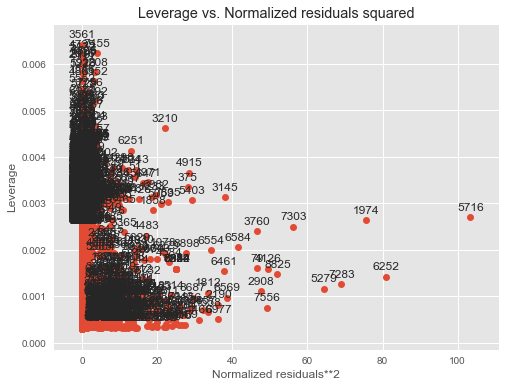

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(ols_m_fe_v1, ax = ax)

#### Betrachtung der Werte

In [73]:
df_reg_v1.Customer_Lifetime_Value.mean()

8004.93017578125

In [74]:
df_reg_v1.Customer_Lifetime_Value.sort_values(ascending=False).head(21)

5716    83325.382812
1974    74228.515625
6252    73225.953125
7283    67907.273438
5279    66025.757812
7303    64618.757812
3760    61850.187500
8825    61134.683594
4126    60556.191406
2908    58753.878906
6584    58207.128906
79      58166.554688
7556    57520.500000
4915    56675.937500
6461    55277.445312
3145    52811.492188
6554    51426.250000
2190    51337.906250
6569    51016.066406
7835    50568.257812
6977    49423.796875
Name: Customer_Lifetime_Value, dtype: float32

#### Ausschließen der Ausreißer

In [75]:
df_reg_v1_less_outliers = df_reg_v1[df_reg_v1.Customer_Lifetime_Value<50000]

#### Erneutes Training mit OLS

In [76]:
ols_m_fe_v1_less_outliers = smf.ols(formula='Customer_Lifetime_Value ~ Monthly_Premium_Auto + Number_of_Open_Complaints + Number_of_Policies + Education_HighSchoolorBelow + Employment_Status_Employed + Marital_Status_Divorced + Policy_Type_SpecialAuto + Policy_CorporateL1 + Policy_CorporateL2 + Vehicle_Size_Small', data=df_reg_v1_less_outliers).fit()
ols_m_fe_v1_less_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.143
Method:                      Least Squares   F-statistic:                     153.5
Date:                     Sun, 09 Dec 2018   Prob (F-statistic):          6.43e-299
Time:                             13:12:31   Log-Likelihood:                -92106.
No. Observations:                     9114   AIC:                         1.842e+05
Df Residuals:                         9103   BIC:                         1.843e+05
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     661.1370    223.231      2.962      0.003     223.555    1098.719
Monthly_Premium_Auto           69.8489      1.827     38.239      0.000      66.268      73.430
Number_of_Open_Complaints    -236.0902     68.241     -3.460      0.001    -369.857    -102.323
Number_of_Policies             93.0469     25.977      3.582      0.000      42.126     143.968
Education_HighSchoolorBelow   300.9523    137.768      2.184      0.029      30.896     571.009
Employment_Status_Employed    577.7870    128.434      4.499      0.000     326.028     829.546
Marital_Status_Divorced       467.8794    174.189      2.686      0.007     126.430     809.328
Policy_Type_SpecialAuto       752.6237    312.366      2.409      0.016     140.317    1364.931
Policy_CorporateL1            571.1980    320.122      1.784      0.074     -56.312    1198.708
Policy_CorporateL2           -485.6608    252.512     -1.923      0.054    -980.641       9.320
Vehicle_Size_Small             47.2124    157.442      0.300      0.764    -261.409     355.834
==============================================================================
Omnibus:                     4883.968   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33877.251
Skew:                           2.545   Prob(JB):                         0.00
Kurtosis:                      10.956   Cond. No.                         522.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Fazit:__  
Blöd, das Ergebnis ist schlechter geworden.

#### Erneuter Residual-vs-Leverage-Plot mit weniger Ausreißern

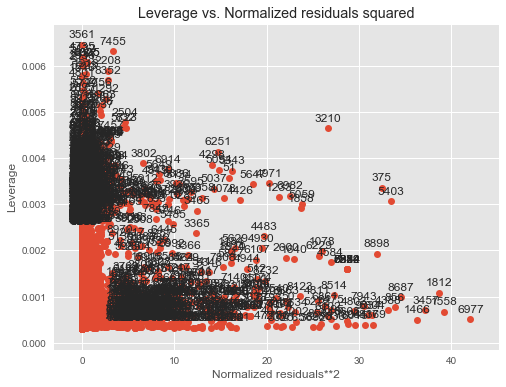

In [94]:
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(ols_m_fe_v1_less_outliers, ax = ax)

### Lasso

#### Erster Versuch mit Baseline-Features mit allen Datensätzen

In [97]:
df_lasso_v1 = df_reg_v1.select_dtypes(np.number)

In [98]:
df_lasso_v1.shape

(9134, 11)

In [99]:
X = np.array(df_lasso_v1.iloc[:,1:])
y = np.array(df_lasso_v1.iloc[:,0])

In [100]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

In [101]:
clf.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
    verbose=False)

In [102]:
clf.alpha_

0.028486937417605163

In [103]:
clf.score(X,y)

0.1619529654739266

In [104]:
clf.intercept_

-16.337646972400762

#### Erneuter Versuch mit Baseline-Features mit weniger Ausreißern

In [105]:
df_lasso_v1_less_outliers = df_reg_v1_less_outliers.select_dtypes(np.number)

In [106]:
df_lasso_v1_less_outliers.shape

(9114, 11)

In [107]:
X = np.array(df_lasso_v1_less_outliers.iloc[:,1:])
y = np.array(df_lasso_v1_less_outliers.iloc[:,0])

In [108]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

In [109]:
clf.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
    verbose=False)

In [110]:
clf.alpha_

0.03787158711134126

In [111]:
clf.score(X,y)

0.14431689175247187

In [112]:
clf.intercept_

685.2877473383132

#### Manueller Versuch

In [113]:
df_lasso_v0 = df_reg_v0.select_dtypes(np.number)
df_lasso_v0.name = 'v0'

df_lasso_v1 = df_reg_v1.select_dtypes(np.number)
df_lasso_v1.name = 'v1'

df_lasso_v2 = df_reg_v2.select_dtypes(np.number)
df_lasso_v2.name = 'v2'

lasso_data = [df_lasso_v0, df_lasso_v1, df_lasso_v2]

In [114]:
alphas = [1,2,10,25,50,75,100,200]
df_lasso_r2 = pd.DataFrame(columns=['r2_train_v0','r2_test_v0',
                                    'r2_train_v1','r2_test_v1',
                                    'r2_train_v2','r2_test_v2'])

coef_dict = {}
for df in lasso_data:
    X = np.array(df.iloc[:,1:])
    y = np.array(df.iloc[:,0])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.75, test_size=0.25, random_state=1)
    
    lasso = Lasso(alpha=2)
    lasso.fit(X_train,y_train)
    print("R^2 der Trainingsdaten: ("+df.name+") \t\t",lasso.score(X_train,y_train))
    print("R^2 der Testdaten: ("+df.name+") \t\t", lasso.score(X_test,y_test))
    
    for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X_train,y_train)
        d1 = {'alpha':alpha,'r2_train_'+df.name:lasso.score(X_train,y_train),'r2_test_'+df.name:lasso.score(X_test,y_test)}
        df_lasso_r2 = df_lasso_r2.append(d1,ignore_index=True)
    
    best_alpha = df_lasso_r2[df_lasso_r2['r2_test_'+df.name]==df_lasso_r2['r2_test_'+df.name].max()]['alpha'].values.item()
    print("Bester alpha Wert ("+df.name+"): \t\t",best_alpha)
    lasso.set_params(alpha = best_alpha)
    lasso.fit(X_train,y_train)
    
    coef_dict[df.name] = pd.Series(lasso.coef_, df.columns[1:])

R^2 der Trainingsdaten: (v0) 		 0.16776232852349326
R^2 der Testdaten: (v0) 		 0.1477253013672274
Bester alpha Wert (v0): 		 75.0
R^2 der Trainingsdaten: (v1) 		 0.16490400429521268
R^2 der Testdaten: (v1) 		 0.14868548418373362
Bester alpha Wert (v1): 		 100.0
R^2 der Trainingsdaten: (v2) 		 0.16288122150308793
R^2 der Testdaten: (v2) 		 0.1515043587606747
Bester alpha Wert (v2): 		 50.0


/Users/studium/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/studium/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/studium/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/studium/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [115]:
df_lasso_r2.groupby('alpha').mean()

,r2_train_v0,r2_test_v0,r2_train_v1,r2_test_v1,r2_train_v2,r2_test_v2
alpha,,,,,,
1.0,0.167769,0.147659,0.164905,0.148642,0.162882,0.151492
2.0,0.167762,0.147725,0.164904,0.148685,0.162881,0.151504
10.0,0.167668,0.148448,0.164884,0.149019,0.162871,0.151591
25.0,0.167332,0.149619,0.164776,0.149562,0.162816,0.151711
50.0,0.166444,0.150872,0.164391,0.150232,0.162619,0.151785
75.0,0.165291,0.151074,0.163749,0.150606,0.162290,0.151702
100.0,0.164086,0.150958,0.162908,0.150639,0.161831,0.151461
200.0,0.159784,0.149827,0.159276,0.149622,0.159235,0.149652


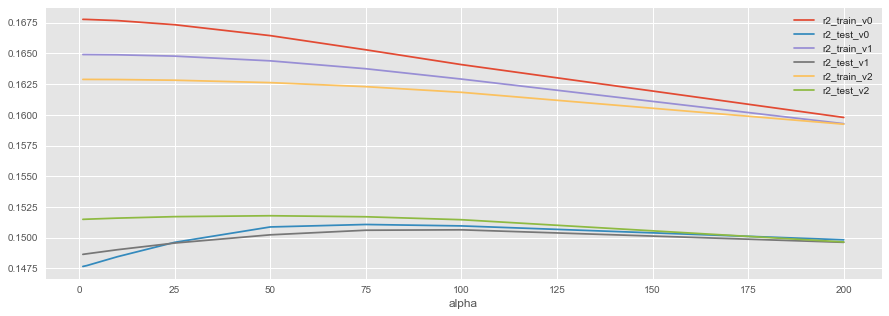

In [116]:
df_lasso_r2.groupby('alpha').mean().plot(figsize=(15,5))

In [117]:
for key in coef_dict:
    print(key+"\n")
    print(coef_dict[key][coef_dict[key] != 0])
    print("*"*100+"\n")

v0

Monthly_Premium_Auto             2.607498e+03
Months_Since_Policy_Inception    6.962233e+00
Number_of_Open_Complaints       -1.652070e+02
Number_of_Policies               8.019136e+01
State_Washington                 3.559648e+00
Education_HighSchoolorBelow      1.403148e+02
Employment_Status_Employed       1.498812e+02
Gender_F                         3.766025e+00
Gender_M                        -1.104477e-13
Location_Code_Suburban          -3.622853e+01
Marital_Status_Divorced          7.200180e+01
Marital_Status_Single           -8.289692e+01
Policy_Type_SpecialAuto          4.957507e+01
Policy_CorporateL1               2.674937e+01
Policy_CorporateL2              -9.842222e+01
Policy_CorporateL3              -3.253013e+01
Vehicle_Class_Four_DoorCar      -8.772106e+01
Vehicle_Class_SUV                1.219441e+02
Vehicle_Class_SportsCar          5.678135e+00
Vehicle_Size_Small               1.733912e+01
Vehicle_Size_Large              -1.362418e+01
dtype: float64
***************

__ToDo:__
+ Kurzer Vergleich der Parameter


### Automatisierte Feature-Selection

In [118]:
df_lasso_v0 = df_reg_v0.select_dtypes(np.number)

In [119]:
X = np.array(df_lasso_v0.iloc[:,1:])
y = np.array(df_lasso_v0.iloc[:,0])

In [120]:
clf = LassoCV(cv=5, n_alphas=100, normalize=True, n_jobs=-1, random_state=1)

In [121]:
sfm = SelectFromModel(clf, threshold='mean')
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

In [122]:
n_features

9

In [123]:
df_lasso_v0.columns[1:][sfm.get_support()]

Index(['Monthly_Premium_Auto', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Employment_Status_Employed',
       'Marital_Status_Single', 'Policy_CorporateL2',
       'Vehicle_Class_Four_DoorCar', 'Vehicle_Class_SUV',
       'Vehicle_Class_SportsCar'],
      dtype='object')

In [124]:
df_coeffs = pd.DataFrame({'feature': df_lasso_v0.columns[1:], 'coeffs': sfm.estimator_.coef_})

In [125]:
df_coeffs[df_coeffs.coeffs!=0]

,coeffs,feature
1,73.807521,Monthly_Premium_Auto
4,-88.704112,Number_of_Open_Complaints
5,18.974971,Number_of_Policies
21,276.865108,Employment_Status_Employed
24,-4.664934,Employment_Status_Unemployed
32,-62.718210,Marital_Status_Single
37,-20.455296,Policy_CorporateL2
45,-67.748731,Vehicle_Class_Four_DoorCar
48,186.927330,Vehicle_Class_SUV
49,67.101729,Vehicle_Class_SportsCar


In [126]:
sfm.estimator_.alpha_

1.4178015880307504

In [127]:
sfm.estimator_.score(X,y)

0.1595371477739237

In [128]:
sfm.estimator_.intercept_

943.1741522103894

Blabla

# Todo
+ MSE Suche über random search für lasso
+ 3 weitere plots anschauen
+ gradient descent?
+ klassifikation?
    + logit
    + baum
    + confusionmatrix

## Communication
The last step is **communication**, an absolutely critical part of any data analysis project. It doesn’t matter how well your models and visualisation have led you to understand the data unless you can also communicate your results to others.

Surrounding all these tools is **programming**. Programming is a cross-cutting tool that you use in every part of the project. You don’t need to be an expert programmer to be a data scientist, but learning more about programming pays off because becoming a better programmer allows you to automate common tasks, and solve new problems with greater ease.

Source: Wickham/Grolemund, 2016